Piyakorn Mona Munegan

Kaggle user name: Mona Munegan https://www.kaggle.com/piyakornmunegan

# Introduction

This notebook is for the image classification project, on the [image/language] dataset and task.  It contains the following sections:

*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.



# Conventional ML Model

The final model that produced the best-performing predictions for the Kaggle submission (Accuracy 60.37%) was an SVC with RBF Kernel + HOG descriptor.  

The combinations are the HOG descriptor, PCA(n_components=0.9), StandardScaler and a conventional SVC RBF Kernel with feater C=100, gamma=0.01. 

The code below handles initialising part, then importing the dataset and exploring what is dataset look like.

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from os.path import join
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix

from google.colab import drive
import time

import pickle
import json

import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive/')

image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral', 'other']
emotions = {0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'sad', 5: 'surprised', 6: 'neutral', 7: 'other'} #EMOTIONS dictionary

EMOTIONS2 = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral']
emotions2 = {0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'sad', 5: 'surprised', 6: 'neutral'} #EMOTIONS2 dictionary

dataset_directory = '/content/drive/My Drive/COMP8220/Project/data/'
saved_model_directory = '/content/drive/My Drive/COMP8220/Project/savedmodel/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data Exploration

In [29]:
#importing image dataset
images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))

images_test_public = np.load(join(dataset_directory, 'PublicTest_faces_only_data_images.npy'))

images_train = images_train.reshape([-1, image_size, image_size])
images_test_public = images_test_public.reshape([-1, image_size, image_size])   

print(images_train.shape)
print(labels_train.shape)
print(images_test_public.shape)
print(f'Faces only dataset has {images_train.shape[1]*images_train.shape[2]} features')

(9328, 48, 48)
(9328,)
(1136, 48, 48)
Faces only dataset has 2304 features


Display what the original array looks like, also a label index, image and a label name.

[[0.77647059 0.77647059 0.77647059 ... 0.78039216 0.78039216 0.78431373]
 [0.         0.         0.         ... 0.07843137 0.06666667 0.78039216]
 [0.00392157 0.         0.         ... 0.09019608 0.08627451 0.78039216]
 ...
 [0.         0.         0.         ... 0.1254902  0.10196078 0.78039216]
 [0.         0.         0.         ... 0.12156863 0.10196078 0.78039216]
 [0.         0.         0.         ... 0.11372549 0.10196078 0.78039216]]
6
neutral


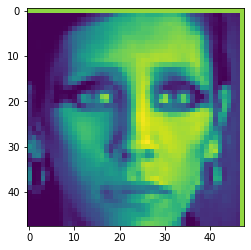

In [30]:
sample = 1
print(images_train[sample])
print(labels_train[sample])
print(EMOTIONS[labels_train[sample]])
plt.imshow(images_train[sample])

Display the first 25 images from the training set and display the class name below each image.

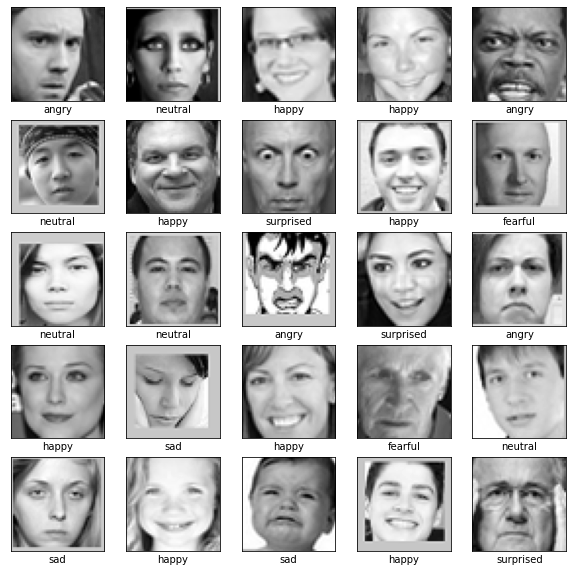

In [31]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral')]

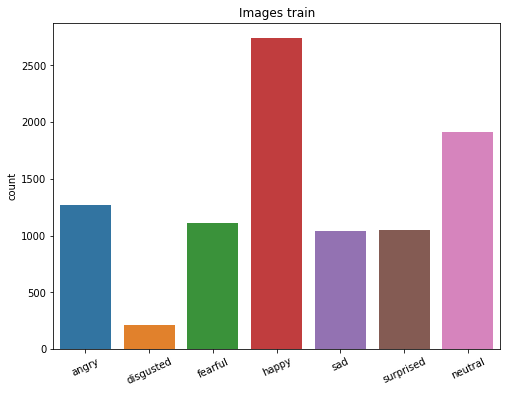

In [34]:
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
sns.countplot(labels_train).set_title('Images train')
ax1.set_xticklabels(emotions.values(), rotation=25)

The number of each label in train and test dataset shows that the most images are happy images, follow by neutral images. The number of angry, fearful, sad images and surprised are similar. The lowest is disgust images (only less than 2% of all labels)

### Histograms of Oriented Gradients (HOG)



__What is Histograms of Oriented Gradients?__

Histograms of Oriented Gradients (HOG) is a feature descriptor introduced by Dalal et al. in 2005. The paper describes HOG as "The HOG captures edge or gradient structure that is very characteristic of local shape, and it does so in a local representation with an easily controllable degree of invariance to local geometric and photometric transformations..."(Dalal & Triggs, 2005)

By applying HOG, the number of features was reduced from 2304 to 900 (a reduction of 39%).


Display images after transformation by HOG.

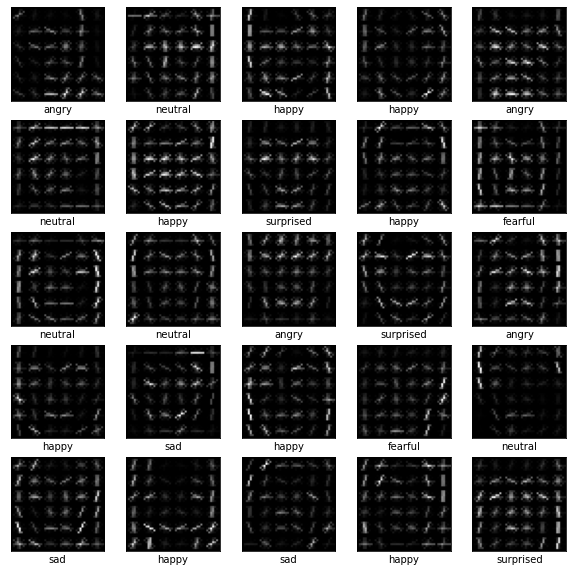

HOG feature vector 900 features


In [ ]:
from skimage.feature import hog

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #Code for HOG image from (Arroyo, 2020) https://github.com/isaacarroyov/fer_without_ann/blob/main/notebooks/fer_without_ann.ipynb
    hog_feature_vector, hog_image = hog(images_train[i], 
                                    orientations=9, 
                                    pixels_per_cell=(8,8), 
                                    cells_per_block=(2,2),
                                    visualize=True, # True if you want the HOG image, default value is False
                                      )
    plt.imshow(hog_image, cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

print(f"HOG feature vector {len(hog_feature_vector)} features")

The code below handles preprocessing dataset by first reshaping the input arrays, then split into train and test test with ratio 70:30 and then ploting check the number of each label in train and test dataset.

## Data preparation

In [ ]:
#Reshape X variables
X = images_train.reshape((images_train.shape[0], -1))
y = labels_train
print(X.shape)
print(y.shape)
print(X[1])

(9328, 2304)
(9328,)
[0.77647059 0.77647059 0.77647059 ... 0.11372549 0.10196078 0.78039216]


Split dataset into training and test sets with a ratio 70:30

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6529, 2304)
(2799, 2304)
(6529,)
(2799,)


Plot the number of each label in train and test dataset

[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral')]

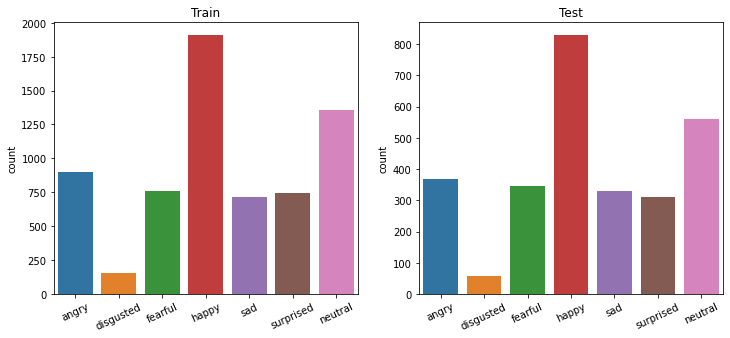

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=y_train, ax=ax1).set_title('Train')
ax1.set_xticklabels(emotions.values(), rotation=25)

sns.countplot(x=y_test, ax=ax2).set_title('Test')
ax2.set_xticklabels(emotions.values(), rotation=25)


All the train, validation and test dataset have the same distribution of labels.

## SVC with RBF Kernel + Hog

In [ ]:
#Code for HOG Descriptor class (Arroyo, 2020) https://github.com/isaacarroyov/fer_without_ann/blob/main/notebooks/OwnTransformers/ImageDescriptors.py
from sklearn.base import BaseEstimator, TransformerMixin

class DescriptorHOG(BaseEstimator, TransformerMixin):
    def __init__(self, hog_orientations = 9, hog_pixels_per_cell = (8,8), hog_cells_per_block=(2,2), hog_block_norm = 'L2', img_dim=(48,48)):
        self.hog_orientations = hog_orientations
        self.hog_pixels_per_cell = hog_pixels_per_cell
        self.hog_cells_per_block = hog_cells_per_block
        self.hog_block_norm = hog_block_norm
        self.img_dim = img_dim

    def fit(self, X, y=None):
        return self

    def feature_hog(self, arr):
        image = arr.reshape(self.img_dim)
        feature_vector = hog(image=image, orientations=self.hog_orientations,pixels_per_cell=self.hog_pixels_per_cell, 
                            cells_per_block=self.hog_cells_per_block, block_norm=self.hog_block_norm)
        return feature_vector

    def transform(self, X):
        X_hog = np.apply_along_axis(func1d=self.feature_hog, axis=1, arr=X)
        return X_hog

The model is defined by pipeline. Firstly, applying the HOG descriptor for decreasing the number of features in data. Secondly, PCA is used for dimensionality reduction. Then StandardScaler for transforming the data to be on the same scale. Lastly, feed the transformed dataset into SVC with RBF Kernel.

The GridSearchCV is applied to find the best hyperparameters for the SVC. Found that the best combination is C=100, gamma=0.01

In [ ]:
#SVC with RBF Kernel + Hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

#Setting hyperparameters
hyperparams = dict(svm__gamma=[0.001, 0.01, 0.1], svm__C = [1, 10, 100, 1_000])

model = Pipeline(steps= [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.9)), #Preserve 90% of its variance.
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
    ])

#Cross Validation for GridSearchCV
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator= model, #Model
    cv= CV, #Cross Validation
    param_grid= hyperparams, #Hyperparameters
    n_jobs=-1, #Use all CPU's
    verbose= 5 #Info
)
#Train across 5 folds, that's a total of (4*3)*5 = 60 rounds of training.
start = time.time()
grid_search.fit(X_train,y_train)
print("Time:", time.time()-start)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Time: 331.2745440006256


In [ ]:
# Best estimator
grid_search.best_estimator_


Pipeline(steps=[('hogdescriptor', DescriptorHOG()),
                ('pca', PCA(n_components=0.9)), ('scaler', StandardScaler()),
                ('svm', SVC(C=100, gamma=0.01))])

In [ ]:
#Run model with the best params from GridSearchCV
start = time.time()
gamma = 0.01
C = 100
pipe_hog = Pipeline(steps = [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.90)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=C, gamma=gamma))
    ])
pipe_hog.fit(X_train, y_train)
y_pred = pipe_hog.predict(X_test)
print("Time:", time.time()-start)
print("Accuracy:", accuracy_score(y_test, y_pred))

Time: 19.230048894882202
Accuracy: 0.6037870668095748


###Analyse Results

In [ ]:
#Confusion Matrix
conf = confusion_matrix(y_test ,y_pred)
#print(conf)
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=EMOTIONS2))

Classification Report
              precision    recall  f1-score   support

       angry       0.49      0.49      0.49       369
   disgusted       1.00      0.39      0.56        57
     fearful       0.60      0.35      0.44       345
       happy       0.71      0.88      0.78       828
         sad       0.55      0.23      0.32       331
   surprised       0.78      0.62      0.69       310
     neutral       0.47      0.67      0.55       559

    accuracy                           0.60      2799
   macro avg       0.66      0.52      0.55      2799
weighted avg       0.61      0.60      0.59      2799



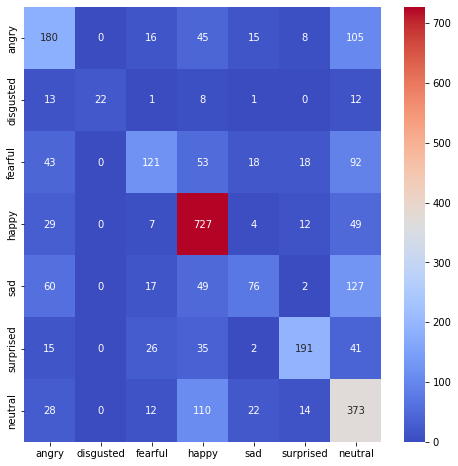

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(conf, annot=True, xticklabels=EMOTIONS2, yticklabels=EMOTIONS2, fmt='g', cmap='coolwarm')
sns.set(font_scale=1.4) # for label size
plt.show()

From the Confusion Matrix, the SVC model performs the best on label happy. Angry and sad are the most categories that the model misclassified prediction to neutral.

### Compare distribution between test labels and predicted labels

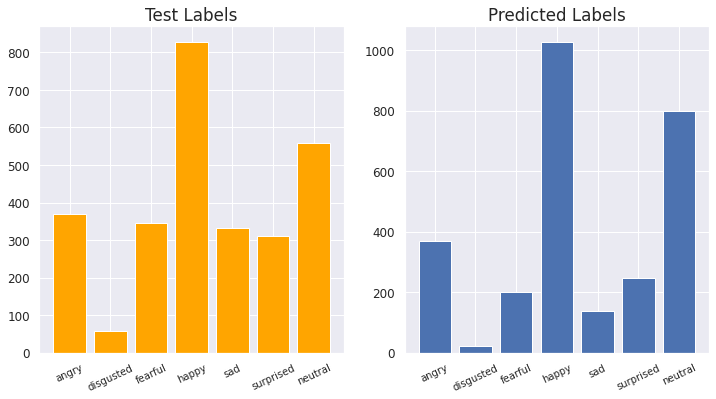

In [ ]:
#I haved modified the plot_image_and_emotion function from (Drcapa 2022) https://www.kaggle.com/code/drcapa/facial-expression-eda-cnn
conv_test_labels = pd.DataFrame()
conv_pred_labels = pd.DataFrame()
conv_test_labels['emotion'] = y_test
conv_pred_labels['emotion'] = y_pred
    
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
x = emotions2.values()
    
y = conv_test_labels['emotion'].value_counts()
keys_missed = list(set(emotions2.keys()).difference(set(y.keys())))
for key_missed in keys_missed:
    y[key_missed] = 0
axs[0].bar(x, y.sort_index(), color='orange')
axs[0].set_title("Test Labels")
axs[0].xaxis.set_tick_params(labelsize=10, rotation=25)
axs[0].yaxis.set_tick_params(labelsize=12)
    
y = conv_pred_labels['emotion'].value_counts()
keys_missed = list(set(emotions2.keys()).difference(set(y.keys())))
for key_missed in keys_missed:
    y[key_missed] = 0
axs[1].bar(x, y.sort_index())
axs[1].set_title("Predicted Labels")
axs[1].xaxis.set_tick_params(labelsize=10, rotation=25)
axs[1].yaxis.set_tick_params(labelsize=12)
plt.show()

From the histograms above, the SVC model has poorly predicted labels fearful, sad and surprised.

# Notes on the Conventional ML Model

For the conventional final model, SVC with RBF Kernel(C=100 with gamma=0.01) gave the highest accuracy(60.38%).

**Data description:**
The data consists of 48x48 pixel grayscale images of human faces. The data contains 9,328 images. The task is to categorise each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).


**Data Exporation:**
The 7 categorise are unbalanced. Happy catagory has the largest number in the dataset. The smallest is from disgusted catagory.


**Pipeline:**
The **HOG** descriptor is used for decreasing the number of features in data.
Then **PCA** is used for dimensionality reduction and applying **StandardScaler** to transform the data to be on the same scale.


**Hyperparameters tuning:**
The GridSearchCV with k-foldCV 5 is applied to find the best hyperparameters for the models

**Model Building:**
Before feeding data into models, the whole dataset was splited into training ad test datasets with a ratio of 70:30 by using train_test_split function.

In addition to the final model, SVC with PCA and StandardScaler without HOG was tried. It gave accuracy of 55.02% (5% lower than the conventional final model).

I also tried a RandomForestClassifier with HOG, PCA and StandardScaler. GridSearchCV found the best combination which is Grmax_depth=15, max_leaf_nodes=100, n_estimators=1000. This performed fairly poorly (accuracy 43.05%). This may be because RandomForestClassifier has many more parameters to tune and it is difficult to find which parameters have the most important to the dataset. Moreover, the SVC model performs better on sparse data than RandomForest in general.

I also trained data on XGBoost model with parameters:
learning_rate = 0.3,
max_depth = 2,
colsample_bytree = 1,
subsample = 1,
min_child_weight = 1,
gamma = 0

The XGBoost performed better than RandomForestClassifier but worst than SVC. It gave an accuracy of 51.48%. I was not successful to perform hyperparameters tuning so I cannot conclude whether SVC or XGBoost is better for this face expression classification task. 


Table1: Conventional models accuracy

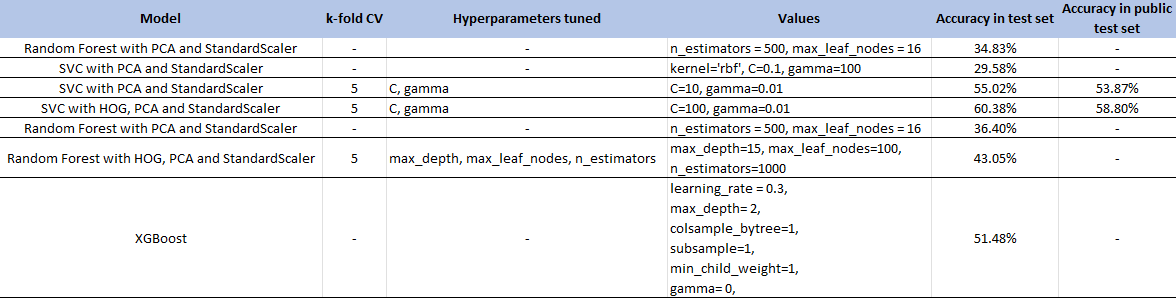

# Deep Learning Model

The final model (named "CNNBest") produced the best-performing predictions for the Kaggle submission (accuracy 75%) was a CNN model with 6 convolutional layers.

The final CNN Architecture:
```
model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(no_class, activation="softmax")
])

```

All Conv2Ds and a dense layer using kernel size = 3 and using activation="elu", kernel_initializer='he_normal'



 I used activation **"ELU"** instead of **"ReLU"** because it performs better than "ReLU" and can overcome the **dying ReLU problem**. **Kernel_initializer='he_normal'** 
gives a good variance for the distribution in terms of statistics and it suits with ELU.

**BatchNormalization** makes each epoch slower to train, but convergence is faster.

**Dropout** layers are applyed to avoid the **overfitting** issue.

A **softmax activation** is used in the output layer to get probability distribution to carry out a classification problem.


In [86]:
# Recreate the best CNN model, including its weights and the optimizer
CNNBest = tf.keras.models.load_model(saved_model_directory +'CNN8.h5')

This diagram shows the CNN model architecture

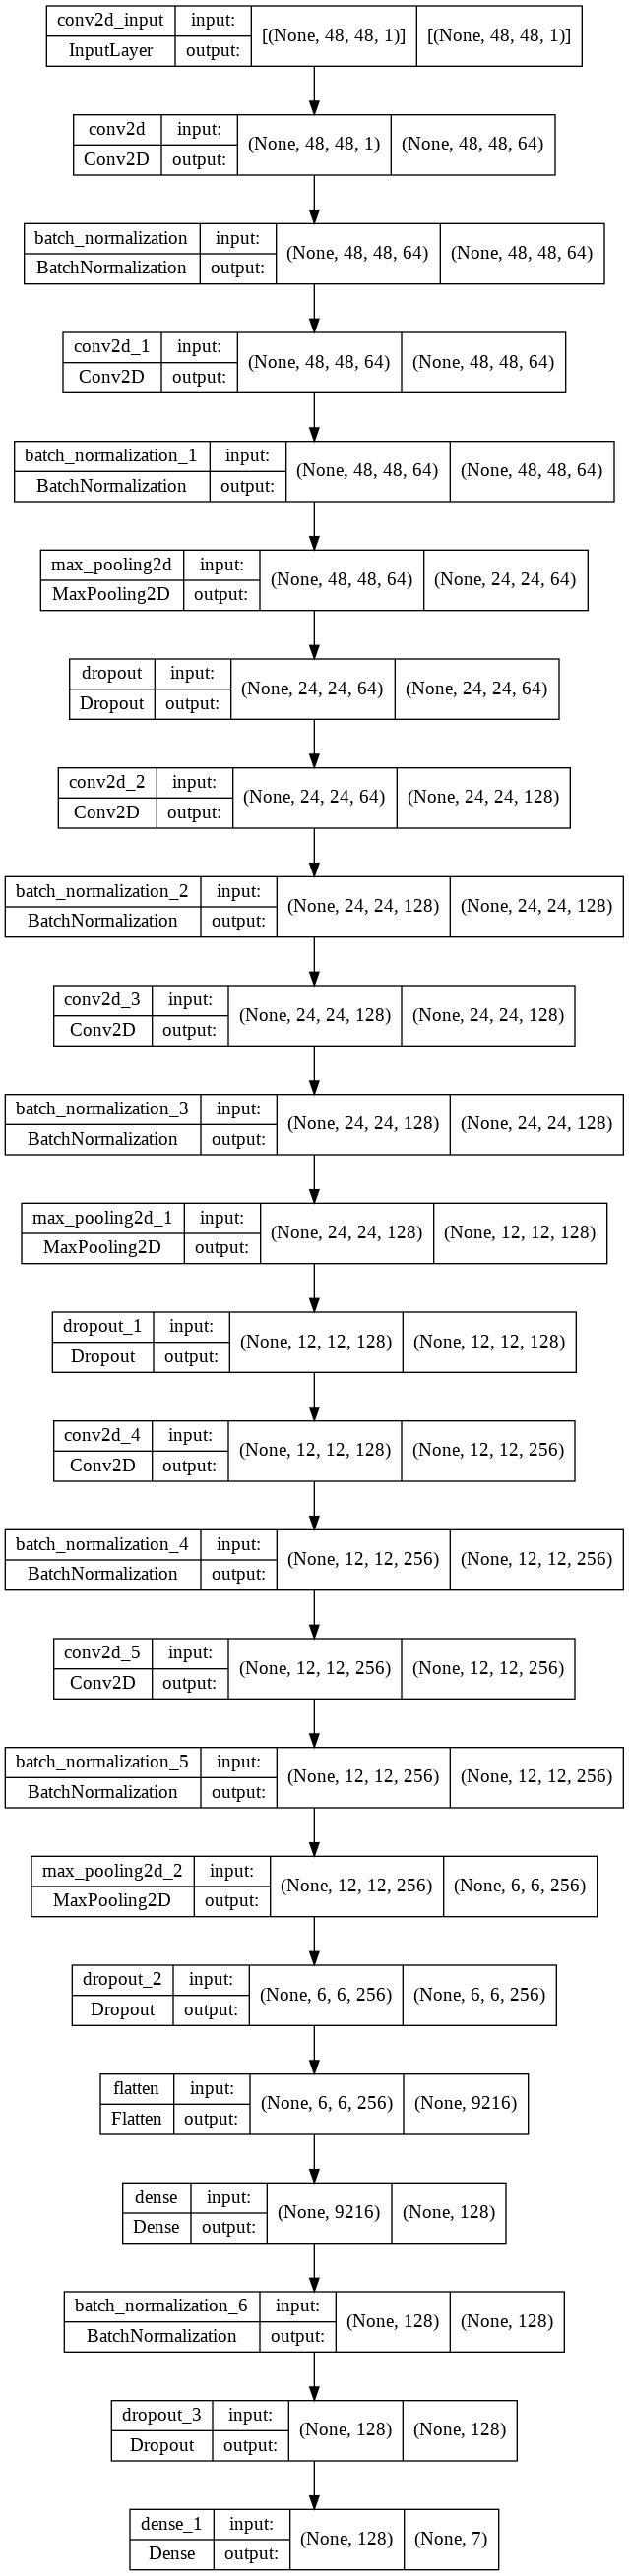

In [87]:
tf.keras.utils.plot_model(CNNBest, to_file='CNNBest.png', show_shapes=True, show_layer_names=True)

## Face only

### Data Exploration


In order to build deep learning models. Frist, I experimented on the original training data images then I found the larger facial expression recognition named FER2013 from Kaggle competition(https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data). I trained the model on the FER2013 dataset and got a higher score when submitted to Kaggle on both face-only and out-of-domain competitions. 

#### FER2013

In [73]:
filname = '/content/drive/My Drive/COMP8220/Project/data/fer2013.csv'
names=['emotion','pixels','usage']
df=pd.read_csv('/content/drive/My Drive/COMP8220/Project/data/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

emotion                                             pixels     usage
0  emotion                                             pixels     Usage
1        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
2        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
3        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
4        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
5        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
6        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...  Training
7        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...  Training
8        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...  Training
9        3  85 84 90 121 101 102 133 153 153 169 177 189 1...  Training

Read the CSV file and create array of X(image) and Y(label) and divide the values by 255(Rescale values to a range of 0 to 1)

In [74]:
#get data from csv function from (Shawon 2019) https://www.kaggle.com/code/shawon10/facial-expression-detection-cnn/notebook
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

There are 7 labels

In [75]:
FER2013_images, FER2013_labels = getData(filname)
num_class = len(set(FER2013_labels))
print(num_class)

7


In [76]:
print(FER2013_images.shape)
print(FER2013_labels.shape)

(35887, 2304)
(35887,)


There are 35,887 images in the FER2013 dataset. Each image is represented as 48 x 48 pixels

In [77]:
FER2013_images = FER2013_images.reshape([-1, image_size, image_size])
print(FER2013_images.shape)

(35887, 48, 48)


Display the first 25 images from the training set and display the class name below each image.

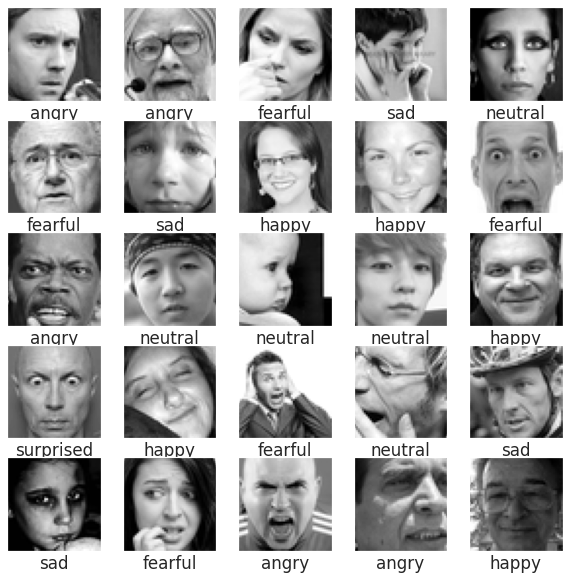

In [78]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(FER2013_images[i], cmap='gray')
    plt.xlabel( EMOTIONS[ FER2013_labels[i] ] )
plt.show()

### Data Preparation

In [79]:
print(FER2013_images.shape)
print(FER2013_labels.shape)

(35887, 48, 48)
(35887,)


Split dataset into train, validation and test sets with a ratio 70:20:10

In [80]:
X_test_image, X_train_full = FER2013_images[:3500], FER2013_images[3500:]
y_test, y_train_full = FER2013_labels[:3500], FER2013_labels[3500:]

In [81]:
X_valid_image, X_train_image = X_train_full[:7000], X_train_full[7000:]
y_valid, y_train = y_train_full[:7000], y_train_full[7000:]

Keep these images to analyse and display later

In [82]:
print(X_train_image.shape)
print(X_test_image.shape)
print(X_valid_image.shape)

(25387, 48, 48)
(3500, 48, 48)
(7000, 48, 48)


Reshape the array as the CNN model expect input.

In [83]:
#(n_samples, height, width, channels)
X_train = X_train_image.reshape(-1, 48, 48, 1)
X_test = X_test_image.reshape(-1, 48, 48, 1)
X_valid = X_valid_image.reshape(-1, 48, 48, 1)

In [84]:
#~70/20/10
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(25387, 48, 48, 1)
(25387,)
(7000, 48, 48, 1)
(7000,)
(3500, 48, 48, 1)
(3500,)


Plot the number of each label in train and test dataset

[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral')]

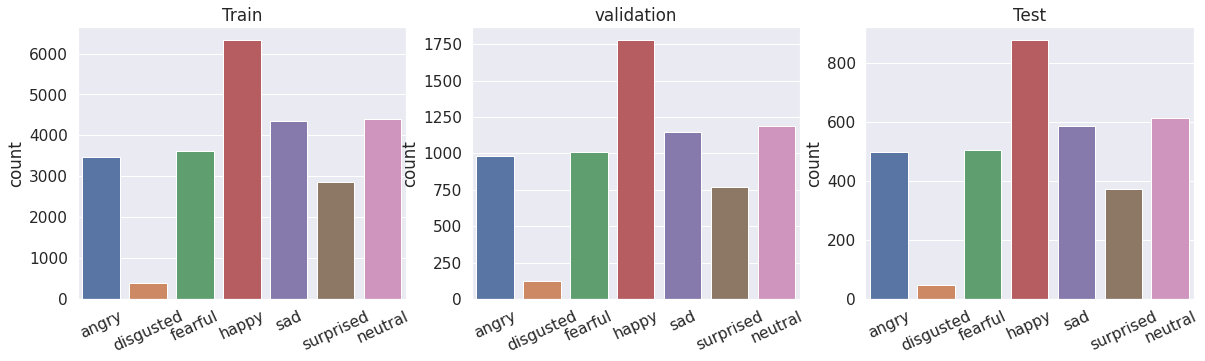

In [85]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
sns.countplot(x=y_train, ax=ax1).set_title('Train')
ax1.set_xticklabels(emotions.values(), rotation=25)
sns.countplot(x=y_valid, ax=ax2).set_title('validation')
ax2.set_xticklabels(emotions.values(), rotation=25)
sns.countplot(x=y_test, ax=ax3).set_title('Test')
ax3.set_xticklabels(emotions.values(), rotation=25)

All the train, validation and test dataset have the same distribution of labels.

### CNN

I started experimenting by following the recommended CNN model from Sharma, 2020 then adjusted several combinations of dropout values. The best dropout combination is all 0.3 after the Conv2D layers and 0.5 before the output layer


To build the final CNN model I also used **EarlyStopping** and **ReduceLROnPlateau** following the recommendation of Sharma, 2020. This also gave the best accuracy with the test dataset

In [ ]:
#Stopping training when a monitored metric has stopped improving
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005, #Minimum change in the monitored quantity to qualify as an improvement,
    patience=11, #	Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True,
)
#Reduce learning rate when a metric has stopped improving
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5, #factor by which the learning rate will be reduced. new_lr = lr * factor.
    patience=7, #number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-7, #lower bound on the learning rate
    verbose=1,
)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

no_class=7
#CNNBest
model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])

Display model summary

In [ ]:
CNNBest.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [ ]:
#CNNBest
data_augmentation = ImageDataGenerator(
                        rotation_range=20, # randomly rotate images in the range (degrees, 0 to 180)
                        width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
                        height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
                        shear_range=0.2, # randomly applying shearing transformations
                        zoom_range=0.2, # randomly zoom image 
                        horizontal_flip=True) # randomly flip images
data_augmentation.fit(X_train)

batch_size = 32 
history = model.fit(data_augmentation.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
793/793 [==============================] - 25s 27ms/step - loss: 2.0497 - accuracy: 0.2250 - val_loss: 1.7015 - val_accuracy: 0.3216 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 21s 27ms/step - loss: 1.7208 - accuracy: 0.3116 - val_loss: 1.5433 - val_accuracy: 0.4054 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 21s 27ms/step - loss: 1.5651 - accuracy: 0.3863 - val_loss: 1.3698 - val_accuracy: 0.4791 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 20s 26ms/step - loss: 1.4494 - accuracy: 0.4414 - val_loss: 1.3241 - val_accuracy: 0.4923 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 20s 26ms/step - loss: 1.3624 - accuracy: 0.4828 - val_loss: 1.2392 - val_accuracy: 0.5309 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 21s 26ms/step - loss: 1.3099 - accuracy: 0.5027 - val_loss: 1.1301 - val_accuracy: 0.5730 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

110/110 [==============================] - 1s 10ms/step - loss: 0.9201 - accuracy: 0.6683


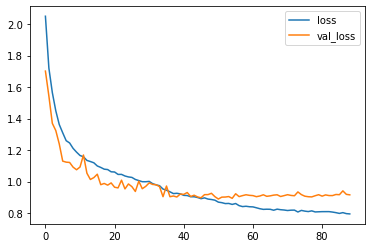

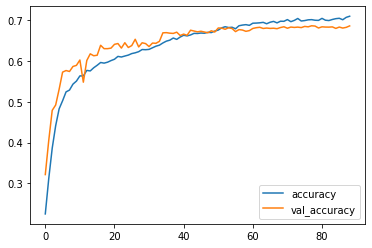

In [ ]:
#CNNBest
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
#plt.savefig(saved_model_directory +'CNN8_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
#plt.savefig(saved_model_directory +'CNN8_accuracy.jpg')

CNNBest accuracy on the face-only test set is 66.83%. The training accuracy and validation accuracy differ by about 2% 

In [ ]:
# Save and load history obj. Dr. Fabien Tarrade https://stackoverflow.com/questions/49969006/save-and-load-keras-callbacks-history
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

In [ ]:
#model.save(saved_model_directory+'CNN8.h5')

#with open(saved_model_directory +'history_CNN8', 'wb') as file:
#    model_history= History_trained_model(history.history, history.epoch, history.params)
#    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

#### Public test faces only dataset

In [ ]:
#PublicTest set
images_test_public = np.load(join(dataset_directory, 'PublicTest_faces_only_data_images.npy'))

Display the first 25 images from the public test faces only dataset.

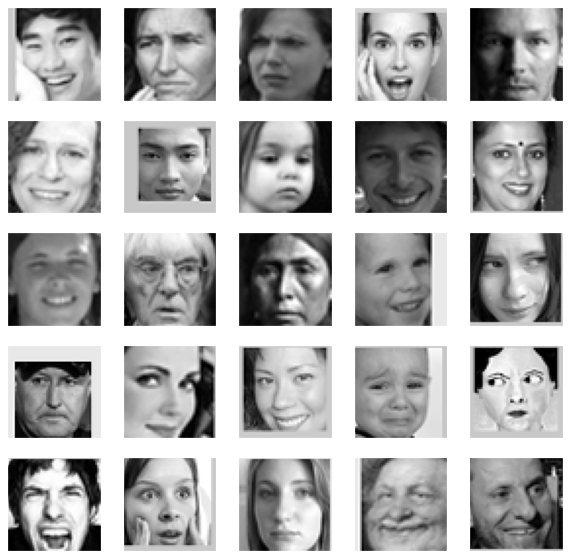

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public[i], cmap='gray')
plt.show()

In [ ]:
#1136
X_public = images_test_public
print(X_public.shape)

(1136, 48, 48)


Reshape an array of the public test faces-only to be ready to feed into the model

In [ ]:
X_public = X_public.reshape(-1, 48, 48, 1)
print(X_public.shape)

(1136, 48, 48, 1)


In [ ]:
X_public_pred = (CNNBest.predict(X_public) > 0.5).astype("int32")
X_public_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
result = []
for i in range(len(X_public_pred)):
  r = np.argmax(X_public_pred[i])
  result.append(r)
X_public_pred_arr = np.array(result)
X_public_pred_arr

array([3, 4, 0, ..., 3, 4, 3])

Display the first 25 images from the public test faces only dataset and display the predicted label name below each image.

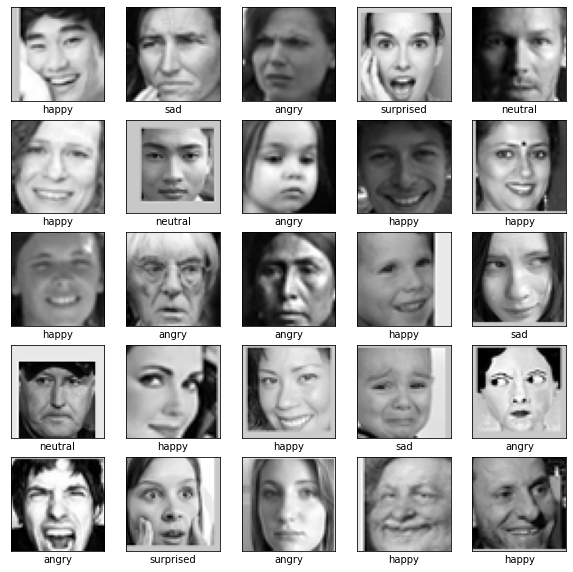

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public[i], cmap='gray')
    plt.xlabel( EMOTIONS[ X_public_pred_arr[i] ] )
plt.show()

Create CSV file of the predicted labels

In [ ]:
id = []
for i in range(len(X_public_pred_arr)):
  id.append(i)

public_pred = X_public_pred_arr.tolist()
output = pd.DataFrame({'ID':id, 'Predictions':public_pred})

# Generate PUBLIC test csvs
output.to_csv(join(dataset_directory, '46318461_deep_CNNI.csv'), index=False, header=True,  encoding='utf-8')

###Analyse Results

In [88]:
predicted_label = CNNBest.predict(X_test)
y_pred = np.argmax(predicted_label, axis = 1)
cm  = confusion_matrix(y_test, y_pred)

In [89]:
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=EMOTIONS2))

Classification Report
              precision    recall  f1-score   support

       angry       0.58      0.60      0.59       498
   disgusted       0.77      0.50      0.61        46
     fearful       0.54      0.40      0.46       505
       happy       0.86      0.89      0.88       878
         sad       0.54      0.57      0.56       585
   surprised       0.80      0.72      0.76       373
     neutral       0.59      0.70      0.64       615

    accuracy                           0.67      3500
   macro avg       0.67      0.63      0.64      3500
weighted avg       0.67      0.67      0.67      3500



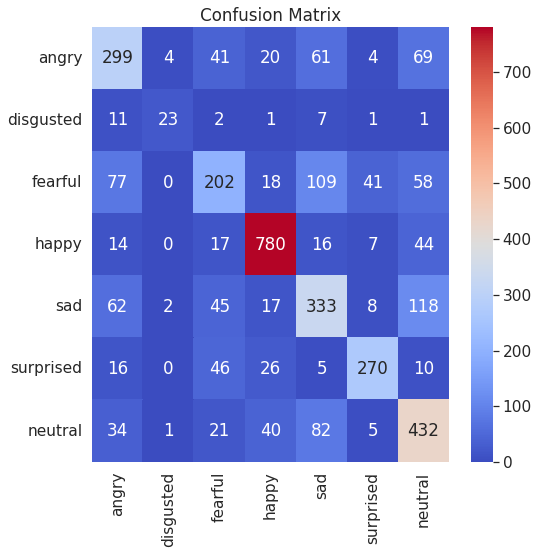

In [90]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, xticklabels=EMOTIONS2, yticklabels=EMOTIONS2, fmt='g', cmap='coolwarm').set(title='Confusion Matrix')
sns.set(font_scale=1.4) # for label size
plt.show()

From the classification report and confusion matrix, the CNNBest performs the best on happy class, followed by surprised class.
Many fearful and neutral images are predicted to the sad class. Vice versa, Many sad images are predicted to the neutral class.

In [91]:
#I haved modified the plot_image_and_emotion function from (Drcapa 2022)#https://www.kaggle.com/code/drcapa/facial-expression-eda-cnn
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=False)
    axs[0].imshow(X_test_image[image_number], 'gray')
    axs[0].set_title("True label: "+ EMOTIONS2[y_test[image_number]])
    axs[1].bar(EMOTIONS2, predicted_label[image_number], color='blue')
    axs[1].set_title("Predicted label: {} {:2.0f}% ".format(EMOTIONS2[y_pred[image_number]], 100*np.max(predicted_label[image_number])))
    axs[1].xaxis.set_tick_params(labelsize=10, rotation=25)
    plt.show()

Let's see some predicted results:


Image 569, true label is happy and predicted label is 100% surely happy! :)

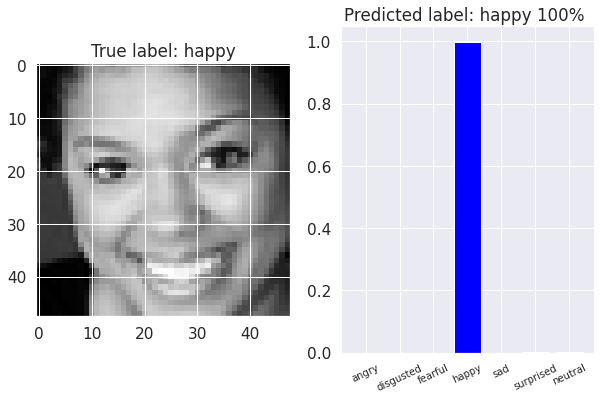

In [92]:
plot_image_and_emotion(X_test_image, y_test, predicted_label, 569)

Image 20, true label is sad and predicted label is 99% sad and 1% neutral.

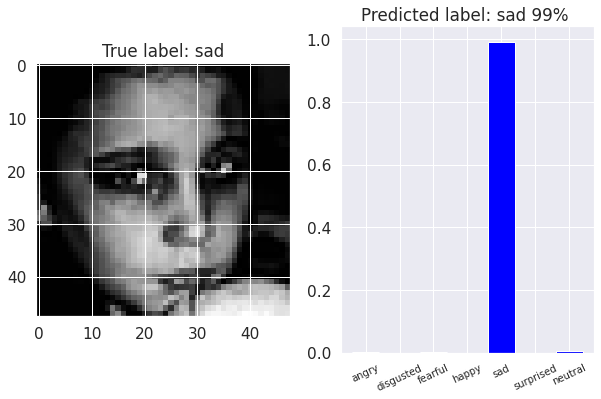

In [93]:
plot_image_and_emotion(X_test_image, y_test, predicted_label, 20)

Image 200, true label is fearful but predicted label is 81% sad with a few % of fearful, happy, angry and neutral.

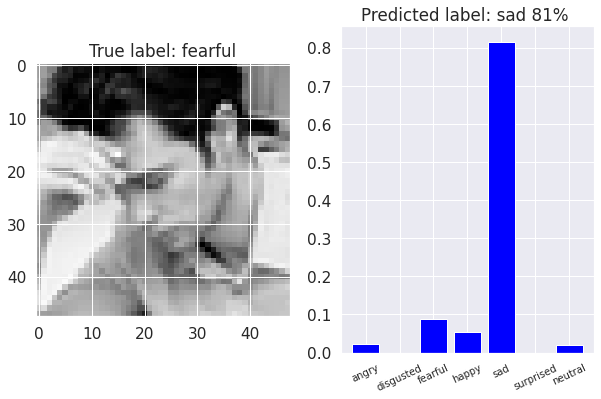

In [94]:
plot_image_and_emotion(X_test_image, y_test, predicted_label, 200)

Image 299, true label is disgusted and predicted label is 77% disgusted with a few % of angry, fearful and sad.

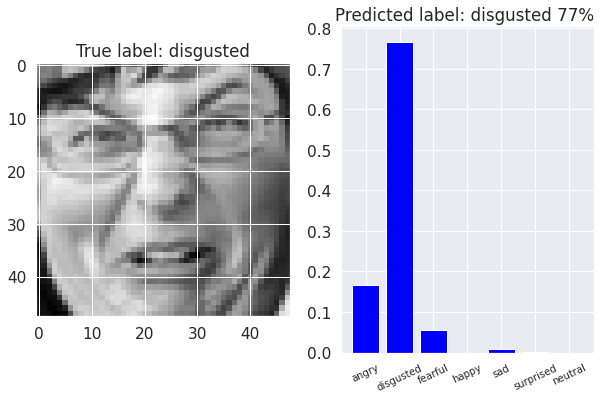

In [95]:
plot_image_and_emotion(X_test_image, y_test, predicted_label, 299)

###Analyse misclassified

In [96]:
print(f'total misclassified predictions: {np.sum(y_pred != y_test)}\n\n')

total misclassified predictions: 1161




In [97]:
label_compare = pd.DataFrame()
label_compare['real'] = y_test
label_compare['pred'] = y_pred
label_compare['wrong'] = np.where(label_compare['real']!=label_compare['pred'], 1, 0)

In [98]:
misclassified = label_compare[label_compare['wrong']==1]
#misclassified

[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral')]

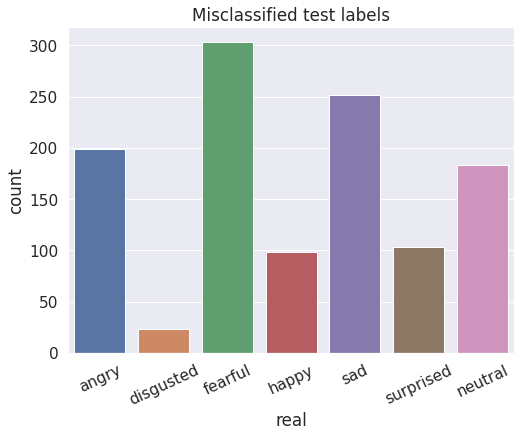

In [99]:
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
sns.countplot(misclassified.real).set_title('Misclassified test labels')
ax1.set_xticklabels(emotions.values(), rotation=25)

From the histogram above, the CNNBest performs poorly on fearful sad, angry and neutral categories.

Image 3124, true label is fearful and predicted label is just 36% neutral. This image has similar probability of sad(36%), fearful(31%) and angry(24%)

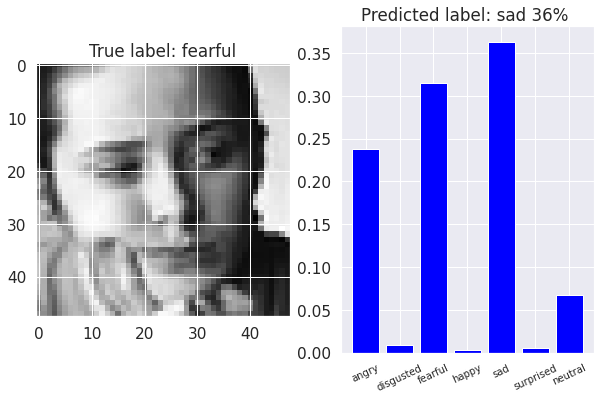

In [ ]:
plot_image_and_emotion(X_test_image, y_test, predicted_label, 3124)

Image 33, this image looks neutral to me, however, true label is fearful and predicted label is 70% neutral. 

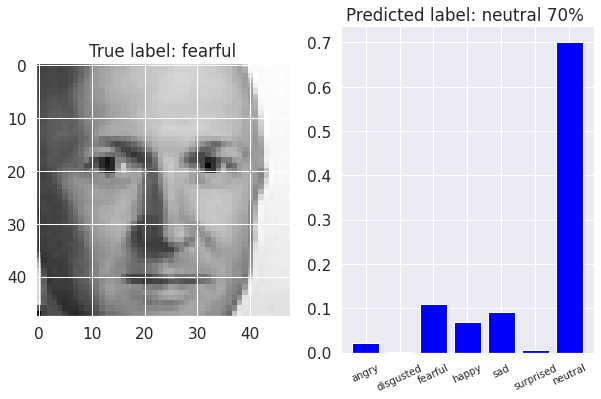

In [ ]:
plot_image_and_emotion(X_test_image, y_test, predicted_label, 33)

Image 3491, true label is sad and predicted label is 49% neutral. This image has not much diffrent in probability of neutral(49% ) and sad(39%).

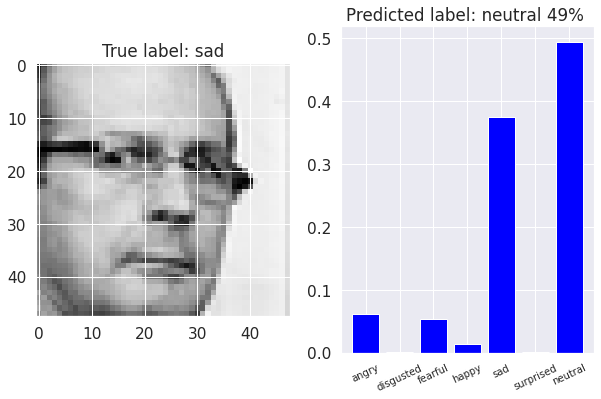

In [ ]:
plot_image_and_emotion(X_test_image, y_test, predicted_label, 3491)

### Compare distribution between test labels and predicted labels

In [ ]:
#I haved modified the plot_compare_distributions function from (Drcapa 2022) https://www.kaggle.com/code/drcapa/facial-expression-eda-cnn
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].xaxis.set_tick_params(labelsize=10, rotation=25)
    axs[0].yaxis.set_tick_params(labelsize=12)
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].xaxis.set_tick_params(labelsize=10, rotation=25)
    axs[1].yaxis.set_tick_params(labelsize=12)
    
    plt.show()

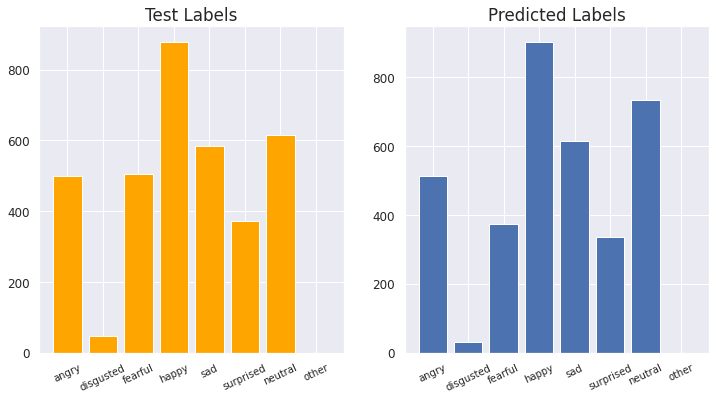

In [ ]:
plot_compare_distributions(y_test, predicted_label, title1='Test Labels', title2='Predicted Labels')

From all the analysis above, we can conclude that the CNNBest performs poorly on fearful sad, angry and neutral categories. We need to improve model by feeding the model more on these categories and make more balance in the training dataset.From all the analyses above, we can conclude that the CNNBest performs poorly in fearful sad, angry and neutral categories. We need to improve the model by feeding the model more on these categories and making more balance in the training dataset.

## Out-of-domain

To make a prediction on Out-of-domain dataset. I trained the best model that I found in Face only part with the FER2013 and MNIST dataset.

### Data Exploration

#### MNIST

Import MNIST dataset and reshape MNIST label array into a  1 dimension array

In [42]:
m_images_train = np.load(join(dataset_directory, 'MNIST_dev_data_images.npy')) #MNIST
m_labels_train = np.load(join(dataset_directory, 'MNIST_dev_data_labels.npy')) #MNIST

m_images_train = m_images_train.reshape([-1, image_size, image_size]) #MNIST

#Reshape MNIST lable
m_labels_train_T = m_labels_train.T #Transpose 
flat_m_labels = m_labels_train_T.flatten() #Flatten 2d numpy array into 1d array

Change all MNIST labels to 7(OTHER)

In [43]:
m_labels = flat_m_labels.copy()
for i in range(len(m_labels)):
    m_labels[i] = 7
m_labels

array([7, 7, 7, ..., 7, 7, 7])

Verify that all the labels are correct by counting unique labels of both dataset

In [44]:
valuesf, countsf = np.unique(FER2013_labels, return_counts=True)
print("Face unique labels: %s count %s" % (valuesf, countsf))
valuesm, countsm = np.unique(flat_m_labels, return_counts=True)
print("Original MNIST unique labels: %s count %s" % (valuesm, countsm))
values, counts = np.unique(m_labels, return_counts=True)
print("Modified MNIST unique labels: %s count %s" % (values, counts))

Face unique labels: [0 1 2 3 4 5 6] count [4953  547 5121 8989 6077 4002 6198]
Original MNIST unique labels: [0 1 2 3 4 5 6 7 8 9] count [141 154 146 141 162 141 155 172 133 155]
Modified MNIST unique labels: [7] count [1500]


There are 35,887 images in the FER2013 dataset and 1,500 images for MNIST dataset. Each image is represented as 48 x 48 pixels

In [45]:
print(FER2013_images.shape)
print(FER2013_labels.shape)
print(m_images_train.shape)
print(m_labels.shape)

(35887, 48, 48)
(35887,)
(1500, 48, 48)
(1500,)


Join array of FACE2013 and MNIST together.

In [46]:
#Concat Face and MNIST image train
FER2013_images_plus_m = np.concatenate((FER2013_images, m_images_train), axis=0)
#Concat Face and MNIST labels train
FER2013_labels_plus_m = np.concatenate((FER2013_labels, m_labels), axis=0)

In [47]:
values, counts = np.unique(FER2013_labels_plus_m, return_counts=True)
print("Face Plus MNIST unique labels: %s count %s" % (values, counts))
print(FER2013_labels_plus_m)

Face Plus MNIST unique labels: [0 1 2 3 4 5 6 7] count [4953  547 5121 8989 6077 4002 6198 1500]
[0 0 2 ... 7 7 7]


#### Public test out-of-domain dataset

In [48]:
#PublicTest set
images_test_public_ood = np.load(join(dataset_directory, 'PublicTest_faces_plus_data_images.npy')) 

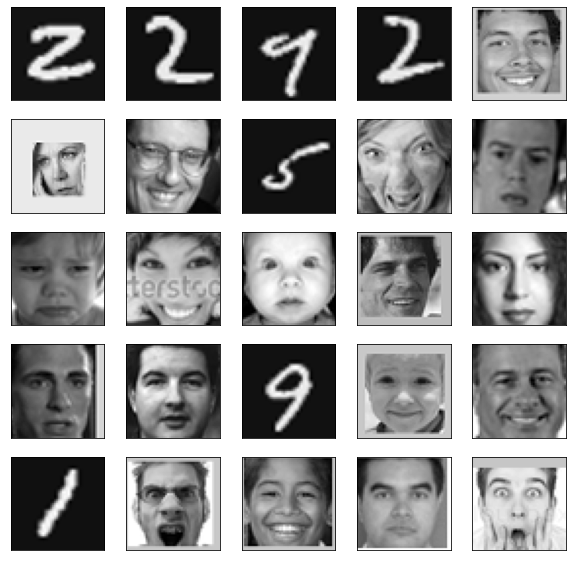

In [49]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public_ood[i], cmap='gray')
plt.show()

### Data Preparation

In [50]:
#35887+1500=37387
print(FER2013_images_plus_m.shape)
print(FER2013_labels_plus_m.shape)

(37387, 48, 48)
(37387,)


In [51]:
full_X_train, X_test_image, full_y_train, y_test = train_test_split(FER2013_images_plus_m, FER2013_labels_plus_m, test_size = 0.1, random_state=42)

In [52]:
X_train_image, X_valid_image, y_train, y_valid = train_test_split(full_X_train, full_y_train, test_size = 0.2, random_state=42)

In [53]:
#Keep these images to analyse and display later
print(X_train_image.shape)
print(X_test_image.shape)
print(X_valid_image.shape)

(26918, 48, 48)
(3739, 48, 48)
(6730, 48, 48)


In [54]:
#(n_samples, height, width, channels)
X_train = X_train_image.reshape(-1, 48, 48, 1)
X_test = X_test_image.reshape(-1, 48, 48, 1)
X_valid = X_valid_image.reshape(-1, 48, 48, 1)

In [55]:
#~70/20/10
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(26918, 48, 48, 1)
(26918,)
(6730, 48, 48, 1)
(6730,)
(3739, 48, 48, 1)
(3739,)


Plot the number of each label in train and test dataset

[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral'),
 Text(0, 0, 'other')]

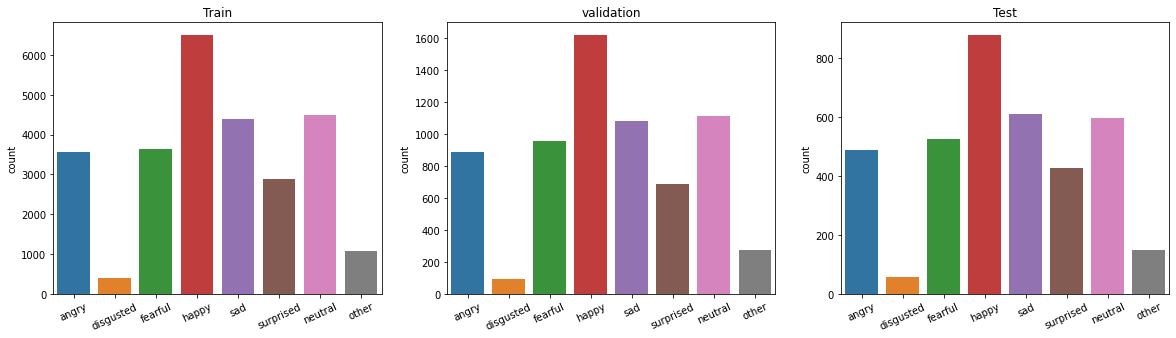

In [56]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
sns.countplot(x=y_train, ax=ax1).set_title('Train')
ax1.set_xticklabels(emotions.values(), rotation=25)
sns.countplot(x=y_valid, ax=ax2).set_title('validation')
ax2.set_xticklabels(emotions.values(), rotation=25)
sns.countplot(x=y_test, ax=ax3).set_title('Test')
ax3.set_xticklabels(emotions.values(), rotation=25)

### CNN

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

no_class=8
#CNNBest
model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
#CNNBest
data_augmentation = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_augmentation.fit(X_train)

batch_size = 32 
history = model.fit(data_augmentation.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
841/841 [==============================] - 26s 28ms/step - loss: 2.0028 - accuracy: 0.2499 - val_loss: 1.6966 - val_accuracy: 0.3247 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 23s 27ms/step - loss: 1.6907 - accuracy: 0.3299 - val_loss: 1.4890 - val_accuracy: 0.4073 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 22s 27ms/step - loss: 1.5210 - accuracy: 0.4125 - val_loss: 1.3247 - val_accuracy: 0.4918 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 23s 27ms/step - loss: 1.4196 - accuracy: 0.4568 - val_loss: 1.2667 - val_accuracy: 0.5221 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 23s 27ms/step - loss: 1.3404 - accuracy: 0.4880 - val_loss: 1.2307 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 23s 27ms/step - loss: 1.2866 - accuracy: 0.5125 - val_loss: 1.1503 - val_accuracy: 0.5627 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

117/117 [==============================] - 1s 8ms/step - loss: 0.8857 - accuracy: 0.6916


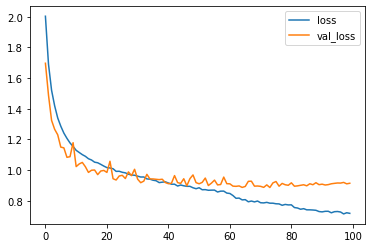

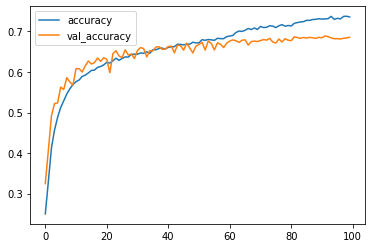

In [ ]:
#CNNBest
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
#plt.savefig(saved_model_directory +'CNN8_OOD_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
#plt.savefig(saved_model_directory +'CNN8_OOD_accuracy.jpg')

CNNBest accuracy on the out-of-domain test set is 69.16%

The training accuracy and validation accuracy differ by about 5% since around the 80th epoch. This difference is acceptable. If the difference is more than 10%, we may assume that the model is overfitting.

In [ ]:
#model.save(saved_model_directory+'CNN8_OOD.h5')

#with open(saved_model_directory +'history_CNN8_OOD', 'wb') as file:
#    model_history= History_trained_model(history.history, history.epoch, history.params)
#    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

Predict on public test set

In [ ]:
#1136
X_public = images_test_public_ood
print(X_public.shape)

(1636, 48, 48)


In [ ]:
X_public = X_public.reshape(-1, 48, 48, 1)
print(X_public.shape)

(1636, 48, 48, 1)


In [ ]:
X_public_pred = (model.predict(X_public) > 0.5).astype("int32")
X_public_pred

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [ ]:
result = []
for i in range(len(X_public_pred)):
  r = np.argmax(X_public_pred[i])
  result.append(r)
X_public_pred_arr = np.array(result)
X_public_pred_arr

array([7, 7, 7, ..., 2, 7, 7])

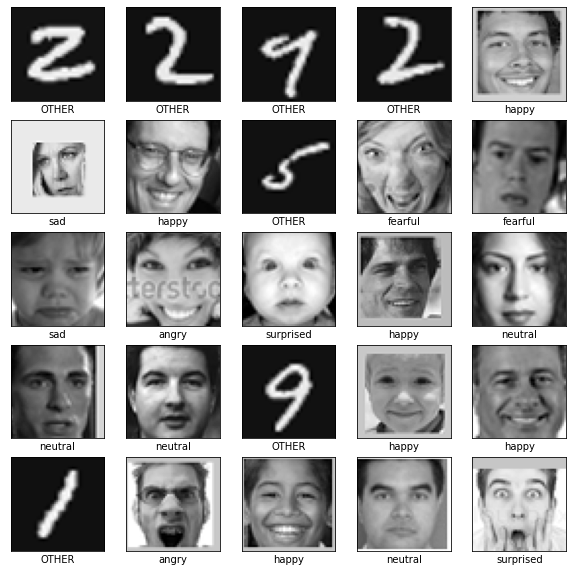

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public_ood[i], cmap='gray')
    plt.xlabel( EMOTIONS[ X_public_pred_arr[i] ] )
plt.show()

In [ ]:
id = []
for i in range(len(X_public_pred_arr)):
  id.append(i)

public_pred = X_public_pred_arr.tolist()
output = pd.DataFrame({'ID':id, 'Predictions':public_pred})

# Generate PUBLIC test csvs
output.to_csv(join(dataset_directory, '46318461_deep_CNNO.csv'), index=False, header=True,  encoding='utf-8')

###Analyse Results

In [57]:
# Recreate the best CNN model, including its weights and the optimizer
CNN_OOD = tf.keras.models.load_model(saved_model_directory +'CNN8_OOD.h5')

In [58]:
predicted_label = CNN_OOD.predict(X_test)
y_pred = np.argmax(predicted_label, axis = 1)
cm  = confusion_matrix(y_test, y_pred)

In [59]:
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=EMOTIONS))

Classification Report
              precision    recall  f1-score   support

       angry       0.57      0.63      0.59       490
   disgusted       0.82      0.63      0.71        57
     fearful       0.59      0.48      0.53       526
       happy       0.89      0.85      0.87       879
         sad       0.56      0.53      0.54       611
   surprised       0.81      0.77      0.79       428
     neutral       0.59      0.74      0.66       599
       other       1.00      1.00      1.00       149

    accuracy                           0.69      3739
   macro avg       0.73      0.70      0.71      3739
weighted avg       0.70      0.69      0.69      3739



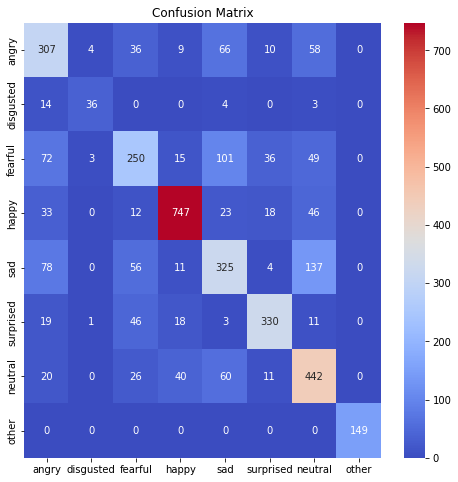

In [60]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, xticklabels=EMOTIONS, yticklabels=EMOTIONS, fmt='g', cmap='coolwarm').set(title='Confusion Matrix')
sns.set(font_scale=1.4) # for label size
plt.show()

From the classification report and confusion matrix, the CNNBest performs the best in other classes. CNNBest can strongly classify the digit images from face images(100%) Followed by the happy, surprised and disgusted classes. The model performs not well in sad and fearful classes.

###Analyse misclassified

In [72]:
print(f'total misclassified predictions: {np.sum(y_pred != y_test)}\n\n')

total misclassified predictions: 1153




In [67]:
label_compare = pd.DataFrame()
label_compare['real'] = y_test
label_compare['pred'] = y_pred
label_compare['wrong'] = np.where(label_compare['real']!=label_compare['pred'], 1, 0)

In [71]:
misclassified = label_compare[label_compare['wrong']==1]
#misclassified

[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral')]

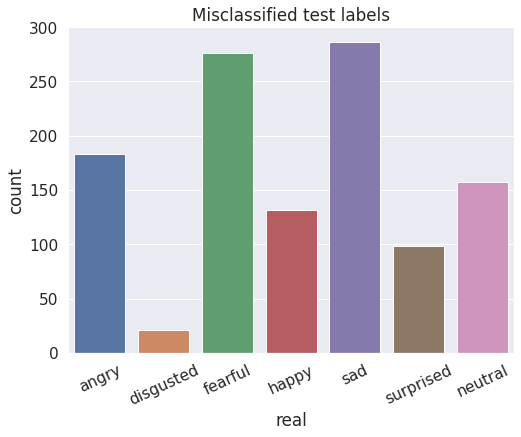

In [69]:
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
sns.countplot(misclassified.real).set_title('Misclassified test labels')
ax1.set_xticklabels(emotions.values(), rotation=25)

Out of total misclassified predictions(1,161 images), the most misclassified label are sad(290 images) and fearful(270 images). Followed by angry(180 images) and netral(150 images). The model performs better in happy and surprised. From 879 happy images, the model misclassified this class only around 130 images. Disgusted class was incorrect classify 21 images from total 57 disgusted images

# Notes on the Deep Learning Model


## Experimented on other models

###Data Augmentation

Before getting the final model, I experimented with **data augmentation**. 
First, followed the CNN model recommended by Sharma, 2020.
The model declaration is below...

```
model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(no_class, activation="softmax")
])

```

Also used same loss function: sparse_categorical_crossentropy, optimizer: Naam, learning rate 0.001 as well as EarlyStopping and ReduceLROnPlateau functions.

```
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

```

Then I compiled the CNN model and fitted the training dataset with different data augmentation sets and got the result on the face-only test set and the out-of-domain test set in Table2.

Table2: CNN with diffrent data augmentation results

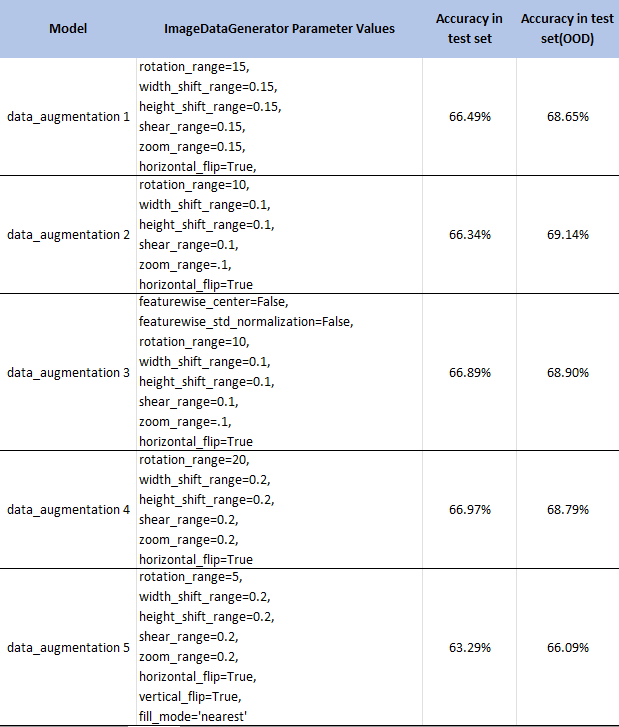

The training and validation loss and accuracy plot of data_augmentation 3

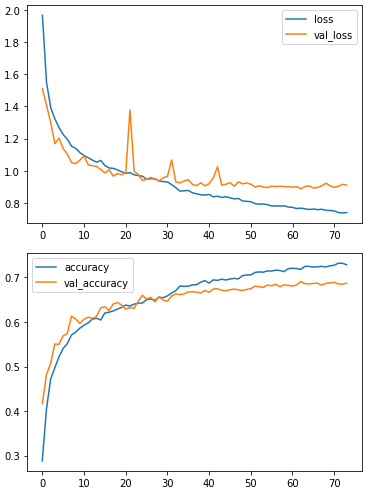

The training and validation loss and accuracy plot of data_augmentation 4

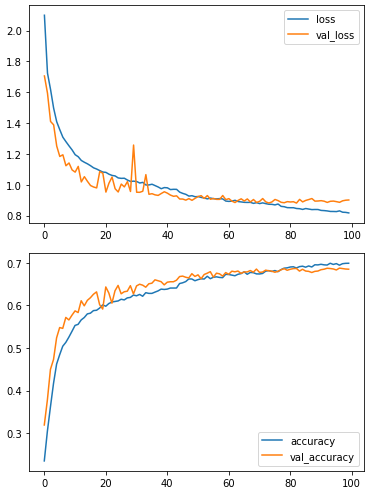

Both the data_augmentation 3 and the data_augmentation 4 gave the best scores on the face-only test set and the out-of-domain test set. However, looking at the training and validation loss and accuracy plot of data_augmentation 3, it seems a little bit overfit after the 50th epoch. The training and validation loss and accuracy plot of data_augmentation 4 shows that the model is a better fit.

Therefore, I chose the data_augmentation 4 to continue the experiment on other CNNs.

###Pre-trained model

For this part, I experimented with 2 pre-trained models which are Restnet50 and VGG16. The result from using Restnet50 as a base model is very poorly on the test dataset(accuracy 25.1%). This may be because the dying RELU issue. 

The VGG16 model with RELU activations(named "VGG16") performs a lot better(accuracy 51.43%).
Then I created another VGG16 model(named "VGG16_2") using ELU instead of RELU to see whether RELU or ELU perform better in the VGG16 model.

The VGG16_2 accuracy is 47.09%, which is lower than VGG16 so we can conclude that RELU activation performs better than ELU activation when using VGG16 as a base model




We need to transform X_train, X_test and X_valid from gray scale to rgb scale as the Pre-trained models expects rgb input.

In [ ]:
X_train_rgb = tf.constant(X_train)
X_train_rgb = tf.image.grayscale_to_rgb(X_train_rgb)

X_test_rgb = tf.constant(X_test)
X_test_rgb = tf.image.grayscale_to_rgb(X_test_rgb)

X_valid_rgb = tf.constant(X_valid)
X_valid_rgb = tf.image.grayscale_to_rgb(X_valid_rgb)

####Restnet50

To build the Restnet50 pre-trained model. 
First, we need to download a MobileNet V2 model as a base model and freeze four convolution layers. Then connect it to flatten layer follow by dense(512 with activation='relu), dropout, dense(256 with activation='relu) and output layer

```
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

# Freeze four convolution layers
for layer in base_model.layers[:-4]:
    layer.trainable=False

inputs = tf.keras.Input(shape=(48, 48, 3))
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(no_class, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
```

In [ ]:
Restnet50 = tf.keras.models.load_model(saved_model_directory +'Restnet50.h5')
Restnet50.evaluate(X_test_rgb, y_test) 

110/110 [==============================] - 3s 18ms/step - loss: 1.8047 - accuracy: 0.2509


[1.8047094345092773, 0.2508571445941925]

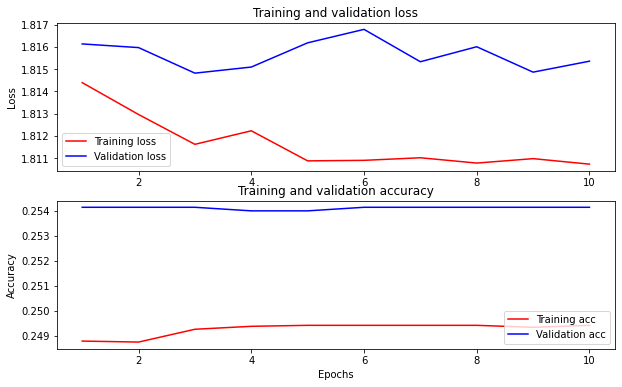

In [ ]:
with open(saved_model_directory +'/history_Restnet50', 'rb') as file:
    historyRestnet50=pickle.load(file)

history_dict = historyRestnet50.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

The training accuracy is steady at 25.4% from the first epoch till the end. Similarly, the validation accuracy is 24.9%. This may be the sign of dying RELU. However, I did not continue to experiment on this Restnet50 pre-trained model. I am not confident if this is the case.

####VGG16

#####VGG16 with RELU

Similay, to build the VGG16 pre-trained model. First, we need to download a VGG16 model as a base model and freeze four convolution layers. Then connect it to flatten layer follow by dense(512 with activation='relu), dropout, dense(256 with activation='relu) and output layer.

```
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze four convolution layers
for layer in base_model.layers[:-4]:
    layer.trainable=False

inputs = tf.keras.Input(shape=(48, 48, 3))
x = vgg_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(no_class, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
```

VGG16 accuracy on the face-only test set is 51.43%

In [47]:
VGG16 = tf.keras.models.load_model(saved_model_directory +'VGG16.h5')

In [ ]:
VGG16.evaluate(X_test_rgb, y_test) 

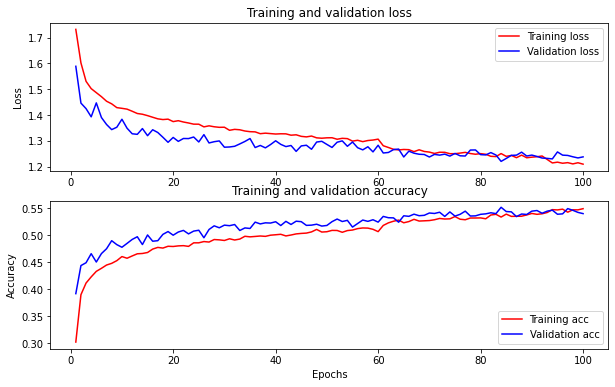

In [ ]:
with open(saved_model_directory +'/history_VGG16', 'rb') as file:
    historyVGG16=pickle.load(file)

history_dict = historyVGG16.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

The VGG model is underfitting as it got only about 55% of accuracy on both the training and validation dataset.

#####VGG16 with ELU

Build VGG_2 same as the VGG model except using activation="elu", kernel_initializer='he_normal' instead of activation="relu".

```
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze four convolution layers
for layer in base_model.layers[:-4]:
    layer.trainable=False
    
inputs = tf.keras.Input(shape=(48, 48, 3))
x = vgg_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="elu", kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="elu", kernel_initializer='he_normal')(x)
outputs = tf.keras.layers.Dense(no_class, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
```

VGG16 accuracy on the face-only test set is 47.09%

In [ ]:
VGG16_2 = tf.keras.models.load_model(saved_model_directory +'VGG16_2.h5')
VGG16_2.evaluate(X_test_rgb, y_test) 

110/110 [==============================] - 1s 10ms/step - loss: 1.3869 - accuracy: 0.4709


[1.3868898153305054, 0.4708571434020996]

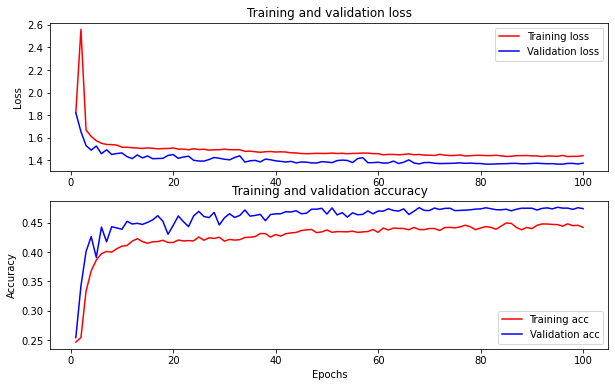

In [ ]:
with open(saved_model_directory +'/history_VGG16_2', 'rb') as file:
    historyVGG16_2=pickle.load(file)

history_dict = historyVGG16_2.history
history_dict.keys()


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

The VGG_2 model is underfitting as it got only about 45% of accuracy on the training and 43% accuracy on the validation dataset.

After I experimented with many combinations on CNN models such as changing dropout values, activation functions, data augmentation, callback, learning scheduler, learning rate, and adding more Conv2D layers.

One of the best models apart from my final model is the CNN model with
```
CNN11 = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    #Addition layer from the final model
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    #Addition layer from the final model
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(no_class, activation="softmax")
])

```
This performed almost as well as the CNNBest on Public Test faces only dataset (accuracy 73.24% which is lower than the best performance at only 2%) This gap in performance may have been because the final model has lower dropout value. If I reduce dropouts value on this CNN11, it may perform better than the CNNBest


CNN11 accuracy on test dataset is 67.69%

In [ ]:
CNN11 = tf.keras.models.load_model(saved_model_directory +'CNN11.h5')
CNN11.evaluate(X_test, y_test) 

110/110 [==============================] - 1s 7ms/step - loss: 0.9023 - accuracy: 0.6769


[0.9023040533065796, 0.6768571138381958]

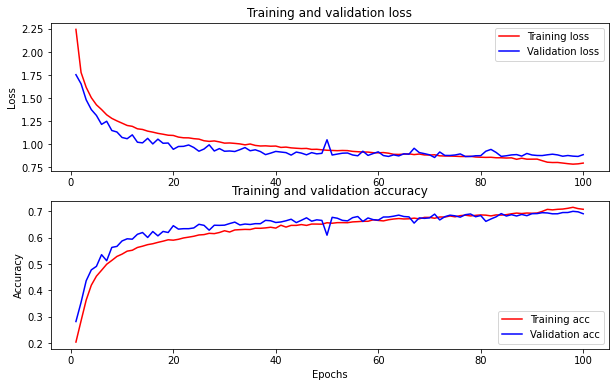

In [ ]:
with open(saved_model_directory +'/history_CNN11', 'rb') as file:
    historyCNN11=pickle.load(file)

history_dict = historyCNN11.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

CNN11 accuracy on test dataset is 67.69%.
The plot of training loss and validation loss decrease to a point of stability. This shows that model has a good fit than the CNNBest. However, the CNNBest model got higher scores when submitted to Kaggle competitions. So I prefer CNNBest to CNN11

# Private test set

## Face-only

In [62]:
#importing image dataset
PrivateTest_data_images = np.load(join(dataset_directory, 'PrivateTest_data_images.npy'))

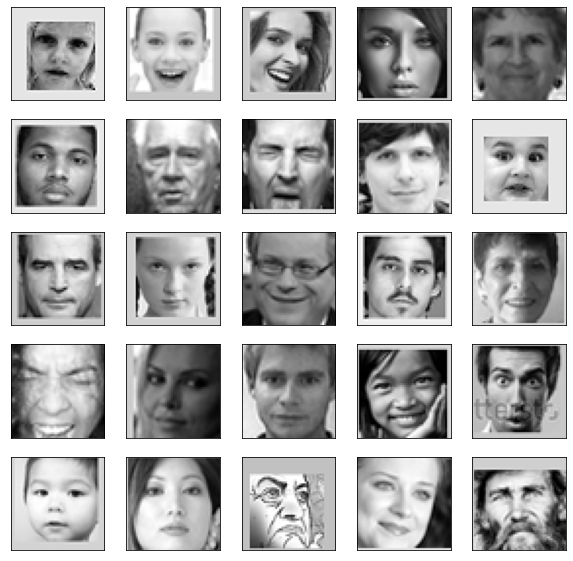

In [63]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(PrivateTest_data_images[i], cmap='gray')
plt.show()

In [64]:
#1153
X_private = PrivateTest_data_images
print(X_private.shape)

(1153, 48, 48)


In [65]:
X_private = X_private.reshape(-1, 48, 48, 1)
print(X_private.shape)

(1153, 48, 48, 1)


In [66]:
CNN11 = tf.keras.models.load_model(saved_model_directory +'CNN11.h5')

In [67]:
X_private_pred = (CNN11.predict(X_private) > 0.5).astype("int32")
X_private_pred

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [68]:
result = []
for i in range(len(X_private_pred)):
  r = np.argmax(X_private_pred[i])
  result.append(r)
X_private_pred_arr = np.array(result)
X_private_pred_arr

array([4, 5, 3, ..., 6, 3, 0])

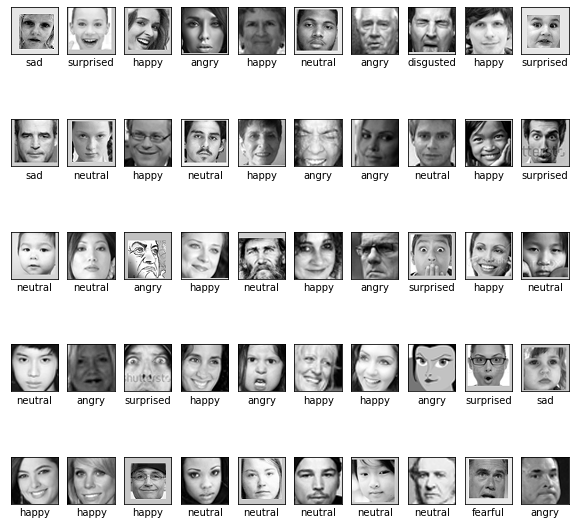

In [69]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(PrivateTest_data_images[i], cmap='gray')
    plt.xlabel(EMOTIONS[X_private_pred_arr[i] ] )
plt.show()

In [70]:
id = []
for i in range(len(X_private_pred_arr)):
  id.append(i)

public_pred = X_private_pred_arr.tolist()
output = pd.DataFrame({'ID':id, 'Predictions':public_pred})

# Generate PUBLIC test csvs
output.to_csv(join(dataset_directory, '46318461_deep_CNN11_private.csv'), index=False, header=True,  encoding='utf-8')

## Face+Data 

In [15]:
PrivateTest_faces_plus_data_images = np.load(join(dataset_directory, 'PrivateTest_faces_plus_data_images.npy'))

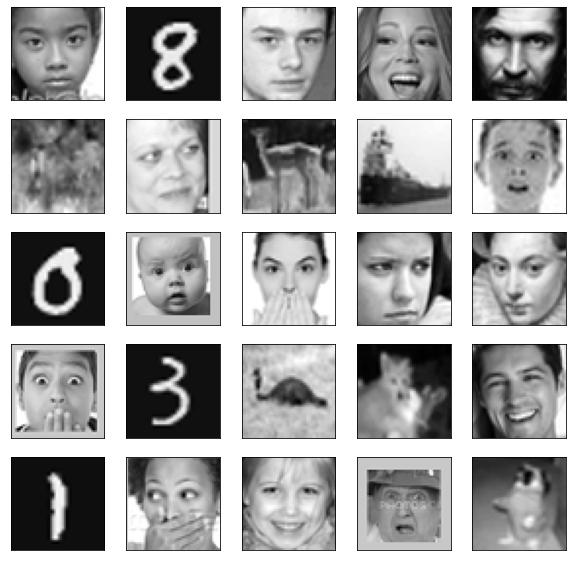

In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(PrivateTest_faces_plus_data_images[i], cmap='gray')
plt.show()

In [17]:
#1753
X_private = PrivateTest_faces_plus_data_images
print(X_private.shape)

(1753, 48, 48)


In [18]:
X_private = X_private.reshape(-1, 48, 48, 1)
print(X_private.shape)

(1753, 48, 48, 1)


In [19]:
CNN11_OOD = tf.keras.models.load_model(saved_model_directory +'CNN11_OOD.h5')

In [20]:
X_private_pred = (CNN11_OOD.predict(X_private) > 0.5).astype("int32")
X_private_pred

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int32)

In [21]:
result = []
for i in range(len(X_private_pred)):
  r = np.argmax(X_private_pred[i])
  result.append(r)
X_private_pred_arr = np.array(result)
X_private_pred_arr

array([6, 7, 6, ..., 7, 5, 2])

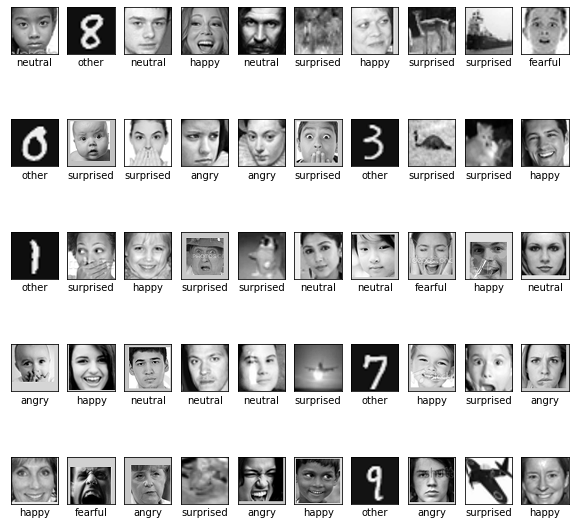

In [22]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(PrivateTest_faces_plus_data_images[i], cmap='gray')
    plt.xlabel(EMOTIONS[X_private_pred_arr[i] ] )
plt.show()

In [23]:
id = []
for i in range(len(X_private_pred_arr)):
  id.append(i)

public_pred = X_private_pred_arr.tolist()
output = pd.DataFrame({'ID':id, 'Predictions':public_pred})

# Generate Private test csvs
output.to_csv(join(dataset_directory, '46318461_deep_CNN11_privateOOD.csv'), index=False, header=True,  encoding='utf-8')

Finally, I tested the deep learning models in the face-only private set and gained an accuracy of 74.15% from the CNNBest and 76.84% from CNN11. Got the 8th of overall positions.

And also for the OOD private set the CNNBest gained an accuracy of 70.79% from  and 65.31% from CNN11. 

# Discussion of Model Performance and Implementation

Comparing my final conventional ML and deep learning models, the deep learning one performed better by 16.2% (SVC = 58.80%, CNN = 75%) on the public test set.  The deep learning model ranked #8 out of 13 submissions on the public face-only test set, with the top-performing system having 92.16% accuracy, and a majority class baseline having 57.04% accuracy 

Comparing performance on private test set versus public test set, 

For face-only dataset: We cannot see any differnt on this face-only dataset. Because the CNNBest gained accuracy of 74.15% on private test set and 75% on public test set.


For out-of-domain dataset:
The models performances on the private test set(70.79%) are much lower than its on the public test set(81.29%)
This is because the models never got training by other data images apart from digits and face expressions. 

At first, I faced the issue of a limitation of RAM and Hardware of Google Colab free version after I trained a few models with FER2013 dataset. These made almost reach the maximum free RAM capacity so I decided to subscribe to Google Colab Pro to solve this issue. After turning on GPU with the High-RAM option I never faced this limited resource issue again.

I also tried to find the other images dataset in the .csv version from the internet to train models more but I only found the image in .jpg version. It is difficult to import .jpg files into notebook without using batch and I do not know how to combine the dataset with batch data. I decied to leave this for further investigations.


#References

[1] Arroyo, I 2021, Facial Expression Recognition (FER) without Artificial Neural Networks, Towards Data Science, July 2021, <https://towardsdatascience.com/facial-expression-recognition-fer-without-artificial-neural-networks-4fa981da9724/>.

[2] Dalal, N & Triggs, B 2005. Histograms of oriented gradients for human detection. In 2005 IEEE computer society conference on computer vision and pattern recognition (CVPR’05) (Vol. 1, pp. 886–893). Ieee.

[3] Sharma, G 2020, Facial Emotion Recognition, <https://www.kaggle.com/code/gauravsharma99/facial-emotion-recognition/notebook4/>.

[4] Drcapa 2022, Facial_Expression_EDA_CNN, <https://www.kaggle.com/code/drcapa/facial-expression-eda-cnn>.

[5] Shawon, A 2019, Facial Expression Detection (CNN), <https://www.kaggle.com/code/shawon10/facial-expression-detection-cnn/notebook>.